In [1]:
# load packages
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import figure
%matplotlib inline
from mne.filter import filter_data

import scipy
from scipy.signal import welch, decimate, periodogram
from scipy import signal
from sklearn.decomposition import PCA
from scipy import stats
from scipy.ndimage.filters import uniform_filter1d

import itertools
import tsfresh as tsf
import time
from datetime import timedelta, datetime
from os.path import join
import os
from os import listdir
from os.path import isfile, join
import csv

from statsmodels.stats.anova import AnovaRM
from sklearn.preprocessing import StandardScaler 
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import pearsonr, mannwhitneyu
import seaborn as sns

/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
path="/Users/jeroenhabets/Desktop/radboud data/data/"
os.chdir(path)

In [3]:
### reading in excel database
startstop = pd.read_excel(path+'startstop.xlsx', sheet_name=0)
print('startstop shape:',startstop.shape)
data = pd.read_excel('Clinical data/Castor exports/Home-based_validation_excel_export_20181129160709/Home-based_validation_excel_export_20181129040711.xlsx', sheet_name=0)
columns = data.keys()
data.shape

pdIds = ['hbv012','hbv013','hbv014','hbv015','hbv016','hbv017','hbv018','hbv022','hbv023','hbv024',
         'hbv038','hbv039','hbv043','hbv047','hbv051','hbv054','hbv058','hbv063','hbv065','hbv074',
'hbv077','hbv079','hbv002','hbv080','hbv090']

bradyOFFitems = ['OFF_UPDRS_3_3a', 'OFF_UPDRS_3_3b', 'OFF_UPDRS_3_3c', 'OFF_UPDRS_3_3d', 'OFF_UPDRS_3_3e', 
 'OFF_UPDRS_3_4a', 'OFF_UPDRS_3_4b', 'OFF_UPDRS_3_5a', 'OFF_UPDRS_3_5b', 'OFF_UPDRS_3_6a',
 'OFF_UPDRS_3_6b', 'OFF_UPDRS_3_7a', 'OFF_UPDRS_3_7b', 'OFF_UPDRS_3_8a', 'OFF_UPDRS_3_8b', 
 'OFF_UPDRS_3_9','OFF_UPDRS_3_14']

bradyONitems = ['ON_UPDRS_3_3a', 'ON_UPDRS_3_3b', 'ON_UPDRS_3_3c', 'ON_UPDRS_3_3d', 'ON_UPDRS_3_3e',
 'ON_UPDRS_3_4a', 'ON_UPDRS_3_4b', 'ON_UPDRS_3_5a', 'ON_UPDRS_3_5b', 'ON_UPDRS_3_6a',
 'ON_UPDRS_3_6b', 'ON_UPDRS_3_7a', 'ON_UPDRS_3_7b', 'ON_UPDRS_3_8a', 'ON_UPDRS_3_8b',
 'ON_UPDRS_3_9', 'ON_UPDRS_3_14']

# create dataframe with pd patients
pdData = data[data['Record Id'].isin(pdIds)]
# create dataframe with bradykinesia info
bkData = pd.DataFrame(data = pdData[['Record Id']+bradyOFFitems+bradyONitems], columns = ['Record Id']+bradyOFFitems+bradyONitems)

#create sum and difference scores
OFF_brady_sum = []
ON_brady_sum = []

for row in range(len(bkData['Record Id'])):
    OFF_brady_sum.append(np.sum(bkData.iloc[row][bradyOFFitems]))
    ON_brady_sum.append(np.sum(bkData.iloc[row][bradyONitems]))

bkData['OFF_brady_sum'] = OFF_brady_sum
bkData['ON_brady_sum'] = ON_brady_sum

bkData['brady_onoff_diff'] = bkData['OFF_brady_sum'] - bkData['ON_brady_sum']

startstop shape: (25, 5)


In [4]:
## take first group of high responders, on off difference > 10
## first two pilot diff 15 and 18: 'hbv013' and 'hbv043'

# make list of only numeric pt id's meeting the requirement
bkIds = []
bkId = list(bkData[bkData['brady_onoff_diff'] >= 10]['Record Id'])
# creating list with updrs differences per patient, in ascending pt-id order
updrsList = []
for pt in bkId:
    bkIds.append(pt[-3:])
    updrsList.append(int(bkData[bkData['Record Id'] == pt]['brady_onoff_diff']))
# select all files in folder containing selected id's
bkFiles= [s for s in listdir(path+'accData (120hz)') if any(xs in s for xs in bkIds) and s[-3:] =='csv']
# creating dictionary per pt with available data series and dataframes
data = {}

for pt in bkIds:
    data[pt] = {}
    for fileName in bkFiles:
        if pt in fileName:
            dataName = fileName.split(pt+'_')[1][:-4]
            data[pt][dataName] = pd.read_csv(path+'accData (120hz)/%s' % fileName, header=None) 
    print(pt,'reading done')
# for every pt: combine x-y-z with resultante (svm) data in new defined dataframe with clear columns  
for pt in data.keys():
    for side in ['L','R']:
        for med in ['pre','post']:
            
            data[pt]['%sW_%smed' % (side,med)] = pd.DataFrame(data = data[pt]['%sW_acceld%smed' % (side,med)])
            keys = data[pt]['%sW_%smed' % (side,med)].keys()
            data[pt]['%sW_%smed' % (side,med)] = data[pt]['%sW_%smed' % (side,med)].rename(columns = {keys[0]: 'X', keys[1]:'Y', keys[2]:'Z'})
            data[pt]['%sW_%smed' % (side,med)]['SVM'] = data[pt]['%sW_acceldr%smed' % (side,med)]
            # delete old data columns and series
            del(data[pt]['%sW_acceld%smed' % (side,med)])
            del(data[pt]['%sW_acceldr%smed' % (side,med)])

    print(pt,'converting done')

## PM: data is already extrapolated from 200 -> 120 hz
## and l1-filter is applied to correct for gravitation (https://web.stanford.edu/~boyd/papers/pdf/l1_trend_filter.pdf)
    

013 reading done
015 reading done
017 reading done
023 reading done
038 reading done
039 reading done
043 reading done
051 reading done
054 reading done
090 reading done
013 converting done
015 converting done
017 converting done
023 converting done
038 converting done
039 converting done
043 converting done
051 converting done
054 converting done
090 converting done


In [6]:
## labels

# All possible labels:
#     1: Sitting
#     2: Standing
#     3: Walking
#     4: Turning
#     5: Stairs
#         5.1: up
#         5.2: down
#     6: Laying
#     7: Postural transition
#         7.1: sit_to_stand_normal_chair
#         7.2: stand_to_sit_normal_chair
#         7.3: sit_to_stand_low_chair_couch
#         7.4: stand_to_sit_low_chair_couch
#         7.5: lie_to_stand
#         7.6: stand_to_lie
#         7.7: sit_to_lie
#         7.8: lie_to_sit
#     8: crosstrainer
#     9: cycling
#     10: running
#     11: motorized_scooter
#     12: riding_car
#     13: push_ups
#     99: unknown

# labels from separate label csv's
# labels200hz = {}
# for pt in data.keys():
#     # create empty list to store act labels per patient
#     labels200hz[pt] = {}
#     for session in ['pre','post']:
#         lab = pd.read_csv(path+'/labels_phys_PD_sharing (200hz)/_labels_PD_phys_sharing_hbv%s_%smedfinal_.csv' % (pt,session))
#         labels200hz[pt]['%sLabels' % session] = lab.rename(columns = {'1':'%sLabels' % session})

#labels from .mat files containing sensors data
labels120hz = {}
for pt in data.keys():
    # create empty list to store act labels per patient
    labels120hz[pt] = {}
    for session in ['pre','post']:
        lab = pd.read_csv(path+'/accData (120hz)/labels (120hz)/hbv%s_labels%smed.csv' % (pt,session))
        labels120hz[pt]['%sLabels' % session] = lab.rename(columns = {'dat':'%sLabels' % session})
        data[pt]['LW_%smed' % session]['actLabels'] = pd.to_numeric(labels120hz[pt]['%sLabels' % session]['%sLabels' % session], downcast='float', errors='coerce')
        data[pt]['RW_%smed' % session]['actLabels'] = pd.to_numeric(labels120hz[pt]['%sLabels' % session]['%sLabels' % session], downcast='float', errors='coerce')




/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
### DOWNSAMPLING TO 60 hz

## always filter first before downsamplign to prevent mirroring of higher frequencies which occur in filtered data (aliasing problem)
## scipy.signal.decimate >> faster than lowpass 30hz and [::2], same circa results
sig = data['013']['LW_premed'][['X']][5000:5360] #'filterY','filterZ','filterSVM'
sig1 = scipy.signal.decimate(np.array(sig), 2, axis=0) # first arg is array, than downsampl factor
# sig2 = filter_data(np.array(sig),120,0.0,30,method='iir',verbose='WARNING')
# sig2=sig2[::2]
data60 = {}
for pt in data.keys():
    data60[pt]={}
    for side in ['L','R']:
        for session in ['pre','post']:
            data60[pt]['%sW_%smed' % (side,session)]= pd.DataFrame(data = data[pt]['%sW_%smed' % (side,session)]['actLabels'][::2])
            for axis in data[pt]['%sW_%smed' % (side,session)].keys()[:4]:
                sig = data[pt]['%sW_%smed' % (side,session)][axis]                
                data60[pt]['%sW_%smed' % (side,session)][axis] = scipy.signal.decimate(np.array(sig), 2, axis=0)





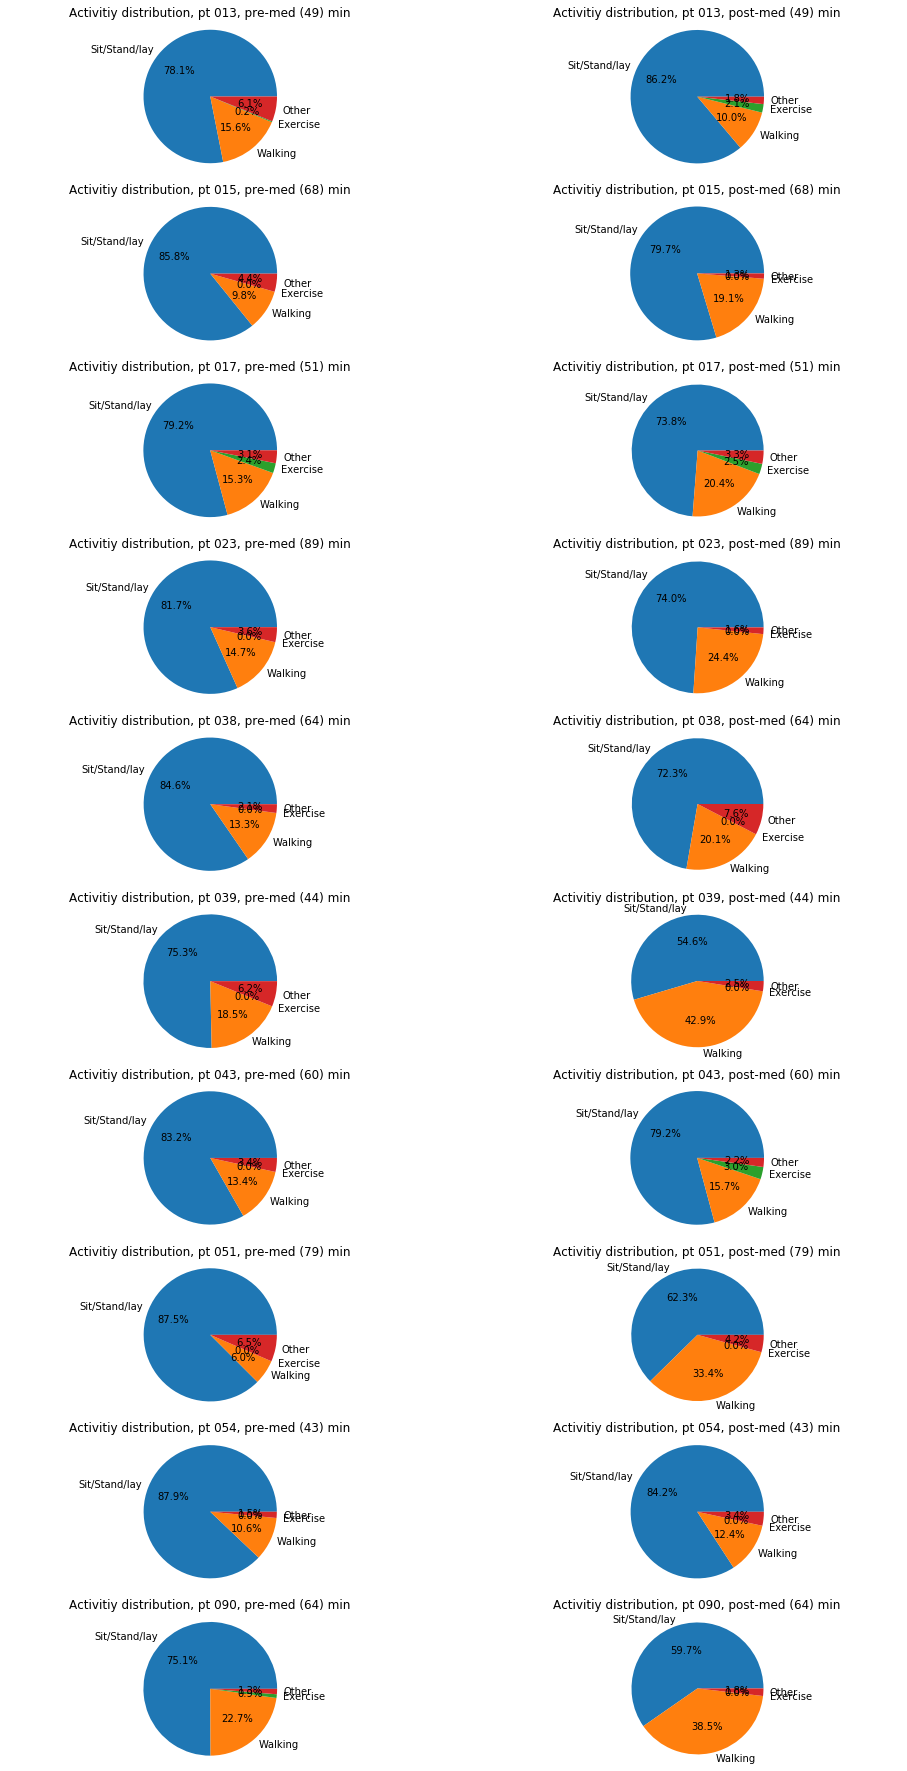

In [9]:
## data check: distribution of activity vs sitting/resting in pre vs post periods
# only LW since activity labels are bilateral equal

fig, axes = plt.subplots(len(data.keys()),2, figsize = (16,32))
for n,pt in enumerate(data.keys()):
    for m,med in enumerate(['LW_premed','LW_postmed']):
        labels = 'Sit/Stand/lay', 'Walking', 'Exercise', 'Other'
        labelCodes = [[1,2,6], [3,5.1,5.2], [8,9,10], [4,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,11,12,13,99]]
        sizes = []
        for l,lab in enumerate(labels):
            num = 0
            for code in labelCodes[l]:
                num = num + np.sum(data[pt][med]['actLabels'] == code)
            sizes.append(round(num/len(data)*100,1))
        explode = (0, 0, 0, 0)  # "explode" means pie 'taken out' [0-1]
        axes[n,m].pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%',  shadow=False) #
        axes[n,m].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        axes[n,0].set_title('Activitiy distribution, pt %s, pre-med (%.0f) min' % (pt, len(data[pt][med]['actLabels'])/120/60))
        axes[n,1].set_title('Activitiy distribution, pt %s, post-med (%.0f) min' % (pt,len(data[pt][med]['actLabels'])/120/60))

plt.show()




## Analyzing question?
### is variation in walking pre vs post problem for classification? Is model then too based on differentiating walking vs non-walking? -> test classifier for separate walking vs non-walking?

In [10]:
## FILTERING RAW SIGNALS (bandpass 0.25 - 4 hz acc to Griffiths)
# filtering all potential input signals (x-y-z-svm) for desired bradykinesia, non-tremor bandwidths
sr=120
# low-pass filtering of raw-axes and raw-svm, storing all days as DataFrames in Dict
filteredData = {}

for pt in data.keys():
    filteredData[pt] = {} # new dict per pt
    # looping over keys/sessions ( LW/RW - pre/post)
    for session in data[pt].keys(): 
        # dat is empty dict for storing filtered data, writing to df at end of session
        cols = list(data[pt][session].keys())[:-1]
        # cols is list of keys within eg LW_pre : x-y-z-svm; exlcuding labels!
        filteredData[pt][session] = pd.DataFrame(data = data[pt][session]['actLabels'], columns = ['actLabels'])
#data = dat, columns = ['filterX','filterY','filterZ','filterSVM']
        for col in cols:
            dat = filter_data(np.array(data[pt][session][col]),sr,0.0,3.5,method='iir',verbose='WARNING')
            filteredData[pt][session]['filter'+col] = dat
#         # calculate SVM after filtering to end up with only positive values
#         filteredData[day]['filterSVM'] = np.sqrt(filteredData[day]['filterX']**2 + filteredData[day]['filterY']**2 + filteredData[day]['filterZ']**2)
#        filteredData[pt][session] = pd.DataFrame(data = dat, columns = ['filterX','filterY','filterZ','filterSVM'])

### RESULT: dataframes per day with filtered X, Y, Z, SVM




In [11]:
## DEFINE FEATURE FUNCTIONS FROM MAHADEVAN 2020

def histogram(signal_x):
    '''
    Calculate histogram of sensor signal.
    :param signal_x: 1-D numpy array of sensor signal
    :return: Histogram bin values, descriptor
    '''
    descriptor = np.zeros(3)

    ncell = np.ceil(np.sqrt(len(signal_x)))

    max_val = np.nanmax(signal_x.values)
    min_val = np.nanmin(signal_x.values)

    delta = (max_val - min_val) / (len(signal_x) - 1)

    descriptor[0] = min_val - delta / 2
    descriptor[1] = max_val + delta / 2
    descriptor[2] = ncell

    h = np.histogram(signal_x, ncell.astype(int), range=(min_val, max_val))

    return h[0], descriptor

def dominant_frequency(signal_df, sampling_rate, cutoff ):
    '''
    Calculate dominant frequency of sensor signals.
    :param signal_df: Pandas DataFrame housing desired sensor signals
    :param sampling_rate: sampling rate of sensor signal
    :param cutoff: desired cutoff for filter
    :param channels: channels of signal to measure dominant frequency
    :return: Pandas DataFrame of calculated dominant frequency for each signal channel
    '''
    dominant_freq_df = pd.DataFrame()

    signal_x = signal_df

    padfactor = 1
    dim = signal_x.shape
    nfft = 2 ** ((dim[0] * padfactor).bit_length())

    freq_hat = np.fft.fftfreq(nfft) * sampling_rate
    freq = freq_hat[0: int(nfft / 2)]

    idx1 = freq <= cutoff
    idx_cutoff = np.argwhere(idx1)
    freq = freq[idx_cutoff]

    sp_hat = np.fft.fft(signal_x, nfft)
    sp = sp_hat[0: int(nfft / 2)] * np.conjugate(sp_hat[0: int(nfft / 2)])
    sp = sp[idx_cutoff]
    sp_norm = sp / sum(sp)

    max_freq = freq[sp_norm.argmax()][0]
    max_freq_val = sp_norm.max().real

    idx2 = (freq > max_freq - 0.5) * (freq < max_freq + 0.5)
    idx_freq_range = np.where(idx2)[0]
    dom_freq_ratio = sp_norm[idx_freq_range].real.sum()

    # Calculate spectral flatness
    spectral_flatness = 10.0*np.log10(stats.mstats.gmean(sp_norm)/np.mean(sp_norm))

    # Estimate spectral entropy
    spectral_entropy_estimate = 0
    for isess in range(len(sp_norm)):
        if sp_norm[isess] != 0:
            logps = np.log2(sp_norm[isess])
        else:
            logps = 0
        spectral_entropy_estimate = spectral_entropy_estimate - logps * sp_norm[isess]

    spectral_entropy_estimate = spectral_entropy_estimate / np.log2(len(sp_norm))
    # spectral_entropy_estimate = (spectral_entropy_estimate - 0.5) / (1.5 - spectral_entropy_estimate)

    dominant_freq_df['_dom_freq_value'] = [max_freq]
    dominant_freq_df['_dom_freq_magnitude'] = [max_freq_val]
    dominant_freq_df['_dom_freq_ratio'] = [dom_freq_ratio]
    dominant_freq_df['_spectral_flatness'] = [spectral_flatness[0].real]
    dominant_freq_df['_spectral_entropy'] = [spectral_entropy_estimate[0].real]

    return dominant_freq_df

def signal_entropy(windowData):
    data_norm = windowData/np.std(windowData)
    h, d = histogram(data_norm)
    lowerbound = d[0]
    upperbound = d[1]
    ncell = int(d[2])

    estimate = 0
    sigma = 0
    count = 0

    for n in range(ncell):
        if h[n] != 0:
            logf = np.log(h[n])
        else:
            logf = 0
        count = count + h[n]
        estimate = estimate - h[n] * logf
        sigma = sigma + h[n] * logf ** 2

    nbias = -(float(ncell) - 1) / (2 * count)

    estimate = estimate / count
    estimate = estimate + np.log(count) + np.log((upperbound - lowerbound) / ncell) - nbias
    
    # Scale the entropy estimate to stretch the range
    estimate = np.exp(estimate ** 2) - np.exp(0) - 1


    
    return estimate



In [12]:

## FEATURE EXTRACTION - 60 sec windows

# INPUT: filtered raw x, y, z, and first PCA, per timepoint, use filteredData
# OUTPUT: features (time and freq domain) per 3-s blocks

sr = 120 # physilog Nijmegen data is extrapolated from sample freq 200 to 120
winLen = 60
tDelta = winLen*sr # raw signal is 120 hz; desired features per 60 sec -> 7200 rows raw-data per 1 feature row

features60s = {} # final dict to save/write features
featDict = {} # empty dictionary to temporarely store feature lists

# create DataFrame per day for final feature storing, in frequency of desired features = 3 sec's windowlength
for pt in list(filteredData.keys()):
    features60s[pt] = {} 
    featDict[pt] = {} 

    for session in list(filteredData[pt].keys()):
        features60s[pt][session] = pd.DataFrame(data = filteredData[pt][session]['actLabels'][::tDelta].reset_index(drop=True), columns = ['actLabels'])
        featDict[pt][session] = {} 
        
        featLabels = [] # start with new empty feature-label list to fill from x until svm

        # feature extraction per axis
        for axis in ['filterX', 'filterY', 'filterZ', 'filterSVM']:
            # create list with all labels per col, to create empty arrays for values
            axLabels = []
            # add list with features for every axis
            featureList = ['_maxAcc', '_coefVar','_accRange', '_RMS','_RMS2', '_specPow_<4Hz', '_specPow_07_14Hz',
                           '_specPow_14_28Hz', '_specPow_Peak', '_domFreq_value', '_domFreq_magnitude', 
                           '_domFreq_ratio', '_spectral_flatness', '_spectral_entropy', '_accEntropy',
                           '_jerkRatio',]
            for feat in featureList:
                axLabels.append(axis+feat)
            # features only for XYZ
            if axis == ('filterX' or 'filterY' or 'filterZ'):
                axLabels.append(axis+'_ratioRMS')
            # features only once in X calculated
            if axis == 'filterX':
                axLabels.extend(['crossCor_XY','crossCor_XZ','crossCor_YZ'])
            # features only once in SVM calculated
            if axis == 'filterSVM':            
                axLabels.append(axis+'_handMov1')
                axLabels.append(axis+'_handMov2')

            featLabels.extend(axLabels) # total list of all feature labels, over all axes

            # create empty list per variable to calculate within axis
            for axLab in axLabels:
                featDict[pt][session][axLab] = [] 
            for windowStart in np.arange(0,len(filteredData[pt][session][axis]),tDelta): 
                # iterate over windows of 60 hz * 3 s       

                windowData = filteredData[pt][session][axis][windowStart : windowStart+tDelta] # create windowdata per column and per window

                ## DISTRIBUTIVE AND DESCRIPTIVE FEATURES FROM TIME DOMAIN
                                
                # Griffiths: max acceleration (not given: per axis or svm?)
                maxAcc = np.max(np.abs(windowData)) # max value of absolute values?
                featDict[pt][session][axis+'_maxAcc'].append(maxAcc)
                
                # other descriptive values
                coefVar = scipy.stats.variation(windowData)
                featDict[pt][session][axis+'_coefVar'].append(coefVar)
                
                # calculate range in signal value; from Mahadevan-Github 
                featDict[pt][session][axis+'_accRange'].append( windowData.max(skipna=True) - windowData.min(skipna=True) )

                # calculate signal entropy; from paper-Github 
                sigEntropy = signal_entropy(windowData)
                featDict[pt][session][axis+'_accEntropy'].append(sigEntropy)                
                
                # number of peaks (tsfresh)
                
                
                # RMS according to classical definition
                meanSqAcc = np.mean(np.square(windowData))
                featDict[pt][session][axis+'_RMS'].append( np.sqrt(meanSqAcc))
                
                # RMS ratio (RMS-axis / RMS-svm) (Sekine '13: https://www.ncbi.nlm.nih.gov/pubmed/24370075)
                # rms ratio in mediolateral direction is correlated with walking speed
                if axis == ('filterX' or 'filterY' or 'filterZ'):
                    svmRMS = np.sqrt(np.mean(np.square(filteredData[pt][session]['filterSVM'][windowStart : windowStart+tDelta])))
                    ratioRMS = meanSqAcc / svmRMS
                    featDict[pt][session][axis+'_ratioRMS'].append(ratioRMS)
                
                ###  Mahadevan: calculate root mean squared per axis, per 3-s window lengths
                featDict[pt][session][axis+'_RMS2'].append( np.std(windowData) - np.mean(windowData))
                
                ### Percentile 10-90 as addition next to mean/median (Rispens 2015 )
                ## https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4296095/?report=classic

                
                
                ## FEATURES FROM SPECTRAL DOMAIN
                
                # Griffiths: MSP: not described: mean over whole 0.2-4.0? mean per which bin-width?? svm or axis?
                freq = np.fft.rfftfreq(len(windowData), d = 1/sr) # define freq's for rfft, resolution (bins/hz) is dependent on windowlength of data
                freq02_40 = np.logical_and(freq < 4, freq > 0.2) # select freq's of interest, total = 0-30hz since sr=60
                all_freq = freq > 0 # only if fft is used and not rfft
                rfft = np.fft.rfft(windowData) # real fast fourier transform (same as fft[freq > 0])
                psd = np.log(np.abs(rfft)**2) # log to normalize (rfft gives same barplot as periodogram and fft)
                ## ??? is PSD correct as squared value of magnitude, log for normalization?
                psd04 = np.sum(psd[freq02_40]) # sum of psd's between selected freq's
                featDict[pt][session][axis+'_specPow_<4Hz'].append(psd04)

                ## Evers (preprint 2020) gait cadence in 0.7 - 1.4 hz and 1.4 - 2.8 hz
                freqGaitA = np.logical_and(freq < 1.4, freq > 0.7) # select freq's of interest, total = 0-30hz since sr=60
                psdGaitA = np.sum(psd[freqGaitA]) # sum of psd's between selected freq's
                featDict[pt][session][axis+'_specPow_07_14Hz'].append(psdGaitA)

                freqGaitB = np.logical_and(freq < 2.8, freq > 1.4) # select freq's of interest, total = 0-30hz since sr=60
                psdGaitB = np.sum(psd[freqGaitB]) # sum of psd's between selected freq's
                featDict[pt][session][axis+'_specPow_14_28Hz'].append(psdGaitB)
                
                # Griffiths: mean PSD around acc peak (every 2 minutes, not described how fft? how broad the range
                # around the peak was taken, etc)
                n_max = np.argmax(psd) # search peak in windowdata
                binHz = len(psd)/(sr/2) # resoution: number of bins (len(psd)) per Hz (sr/2 = 30hz, Nyquist)
                widthPeak = 1 # width around peak in Hz to calculate PSD
                psdPeak = np.sum(psd[int(n_max-(widthPeak/2)*binHz) : int(n_max+(widthPeak/2)*binHz)]) # define width of range around peak
                featDict[pt][session][axis+'_specPow_Peak'].append(psdPeak)

                #Mahadevan: dom freq + ratio + spectral flatness and entropy
                domFreqValues = dominant_frequency(windowData, sr, 4) # 4 = cutoff for spectrum too analyze
                featDict[pt][session][axis+'_domFreq_value'].append( float(domFreqValues['_dom_freq_value']))
                featDict[pt][session][axis+'_domFreq_magnitude'].append( float(domFreqValues['_dom_freq_magnitude']))
                featDict[pt][session][axis+'_domFreq_ratio'].append(float( domFreqValues['_dom_freq_ratio']))
                featDict[pt][session][axis+'_spectral_flatness'].append( float(domFreqValues['_spectral_flatness']))
                featDict[pt][session][axis+'_spectral_entropy'].append( float(domFreqValues['_spectral_entropy']))

        
                # auto-correlation
                if axis == 'filterX':
                    crossCorXY = pearsonr(windowData, filteredData[pt][session]['filterY'][windowStart : windowStart+tDelta])
                    crossCorXZ = pearsonr(windowData, filteredData[pt][session]['filterZ'][windowStart : windowStart+tDelta])
                    crossCorYZ = pearsonr(filteredData[pt][session]['filterY'][windowStart : windowStart+tDelta], filteredData[pt][session]['filterZ'][windowStart : windowStart+tDelta])
                    featDict[pt][session]['crossCor_XY'].append(crossCorXY[0])
                    featDict[pt][session]['crossCor_XZ'].append(crossCorXZ[0])
                    featDict[pt][session]['crossCor_YZ'].append(crossCorYZ[0])


                ## add JERKNESS, rate of acc change (Hogan 2009) acc to Mahadevan
                ampl = np.max(np.abs(windowData))
                jerk = windowData.diff(1) * sr #(divided by 1 / sr => multiply with sr)
                jerkSqSum = np.sum(jerk ** 2)
                scale = 360 * ampl ** 2 / tDelta / sr
                meanSqJerk = jerkSqSum / sr / (tDelta / sr * 2)
                jerkRatio = meanSqJerk / scale
                featDict[pt][session][axis+'_jerkRatio'].append(jerkRatio)                
                

                # Griffiths: time without movement (method for hand movement based on Coeff of Var from Mahadevan)
                # calculates per windowlength, cv(svm) over every second, if 2 or 3 out of 3 are positive, then 3-sec-block is positive
                if axis == 'filterSVM':
                    cv1 = scipy.stats.variation(windowData[:sr]) > 0.01
                    cv2 = scipy.stats.variation(windowData[sr:2*sr]) > 0.01
                    cv3 = scipy.stats.variation(windowData[2*sr:]) > 0.01

                    if np.sum([cv1,cv2,cv3]) > 1.5:
                        handMov = 1
                    else:
                        handMov = 0
                    featDict[pt][session][axis+'_handMov1'].append(handMov)

                    # add second movement feature based on velocity or acc (Keijsers:  velocity is > 0.05 m/s)
                    # from acc (m/s/s) to velocity (m/s) -> start velocity + acc (svm) * seconds
                    # SIMPLIFIED!! if average acc for 3 sec is > 0.05/3 -> veocity will be higher than 0.05 m/s
                    pseudoV = np.mean(windowData)
                    if pseudoV > (0.05/3):
                        handMov2 = 1
                    else:
                        handMov2 = 0
                    featDict[pt][session][axis+'_handMov2'].append(handMov2)
    
        # writing features from dictionary with lists, to columns in actual feature DataFrame
        for label in featLabels:
            features60s[pt][session][label] = featDict[pt][session][label]
    print(pt,'finished')






013 finished
015 finished
017 finished
023 finished
038 finished
039 finished
043 finished
051 finished
054 finished
090 finished


In [13]:
## ANALYZE WHICH FEATURES ARE DIFFERENTIATING BETWEEN WALKING AND SITTING OVER GROUP LEVEL (UN -STDARIZED)
# CREATE WALKING/MOVING FEATURE FOR QUANTITY F MOVEMENT

In [14]:
### TEST IN PT DATA STANDARIZATION

## TEST STD WITH MEANS AND STDS FROM CONV DBS SESSION

## TEST STD WITH 'MOVING AVERAGE', MEANS AND STDS PER HOUR -> LESS VARIATION IN FEATURES?

## TEST STD WITH MEAN AND STDS OF FIRST HOUR AWAKE ?

In [80]:
## creating database per patient, per side; combining on and off, with columns for labeling

featCombi60s = {}
for pt in features60s.keys():
    featCombi60s[pt] = {}
    for side in ['LW','RW']:
        features60s[pt]['%s_premed' % side]['Med'] = 0 
        features60s[pt]['%s_postmed' % side]['Med'] =1 
        featCombi60s[pt][side] = pd.concat([features60s[pt]['%s_premed' % side],features60s[pt]['%s_postmed' % side]],ignore_index=True)

featLabels = list(features60s['013']['LW_premed'].keys())[1:-3] # list without actLabels and Med
svmKeys = []
for key in featCombi60s['043']['LW'].keys():
    if key[6:9] == 'SVM':
        svmKeys.append(key)

xKeys = []
for key in featCombi60s['043']['LW'].keys():
    if key[6:7] == 'X':
        xKeys.append(key)

# for ft in featLabels:
#     if ft[-3:] == 'Var':
#         featLabels.remove(ft)





In [81]:
## creating database per patient, per side; combining on and off, with columns for labeling

# INCLUDE LATER IN FIRST ACT LABELING

actLabelDict = {'Passive' : [1,2,6,], 'Active': [3,5.1,5.2,8,9,10], 'Other': [4,7.1,7.2,7.3,7.4,7.5,7.6,7.7,7.8,11,12,13,99]}
# Passive: Sit/Stand/lay
# Active: 'Walking', 'Exercise'
# Other: turning, transitions, scooter, riding car, pushups, unknown

testData = {}
testData['013'] = featCombi60s['013']
testData['043'] = featCombi60s['043']

# 0: other
# 1: Passive
# 2: Active

for pt in testData.keys():
    for side in testData[pt].keys():
        testData[pt][side]['Act'] = np.zeros(len(testData[pt][side].index))
        for row in testData[pt][side].index:
            if testData[pt][side]['actLabels'][row] in actLabelDict['Passive']:
                testData[pt][side]['Act'][row] = 1
            elif testData[pt][side]['actLabels'][row] in actLabelDict['Active']:
                testData[pt][side]['Act'][row] = 2



/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/jeroenhabets/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [82]:
testData['013']['LW'].keys()

Index(['actLabels', 'filterX_maxAcc', 'filterX_coefVar', 'filterX_accRange',
       'filterX_RMS', 'filterX_RMS2', 'filterX_specPow_<4Hz',
       'filterX_specPow_07_14Hz', 'filterX_specPow_14_28Hz',
       'filterX_specPow_Peak', 'filterX_domFreq_value',
       'filterX_domFreq_magnitude', 'filterX_domFreq_ratio',
       'filterX_spectral_flatness', 'filterX_spectral_entropy',
       'filterX_accEntropy', 'filterX_jerkRatio', 'filterX_ratioRMS',
       'crossCor_XY', 'crossCor_XZ', 'crossCor_YZ', 'filterY_maxAcc',
       'filterY_coefVar', 'filterY_accRange', 'filterY_RMS', 'filterY_RMS2',
       'filterY_specPow_<4Hz', 'filterY_specPow_07_14Hz',
       'filterY_specPow_14_28Hz', 'filterY_specPow_Peak',
       'filterY_domFreq_value', 'filterY_domFreq_magnitude',
       'filterY_domFreq_ratio', 'filterY_spectral_flatness',
       'filterY_spectral_entropy', 'filterY_accEntropy', 'filterY_jerkRatio',
       'filterZ_maxAcc', 'filterZ_coefVar', 'filterZ_accRange', 'filterZ_RMS',
       

013


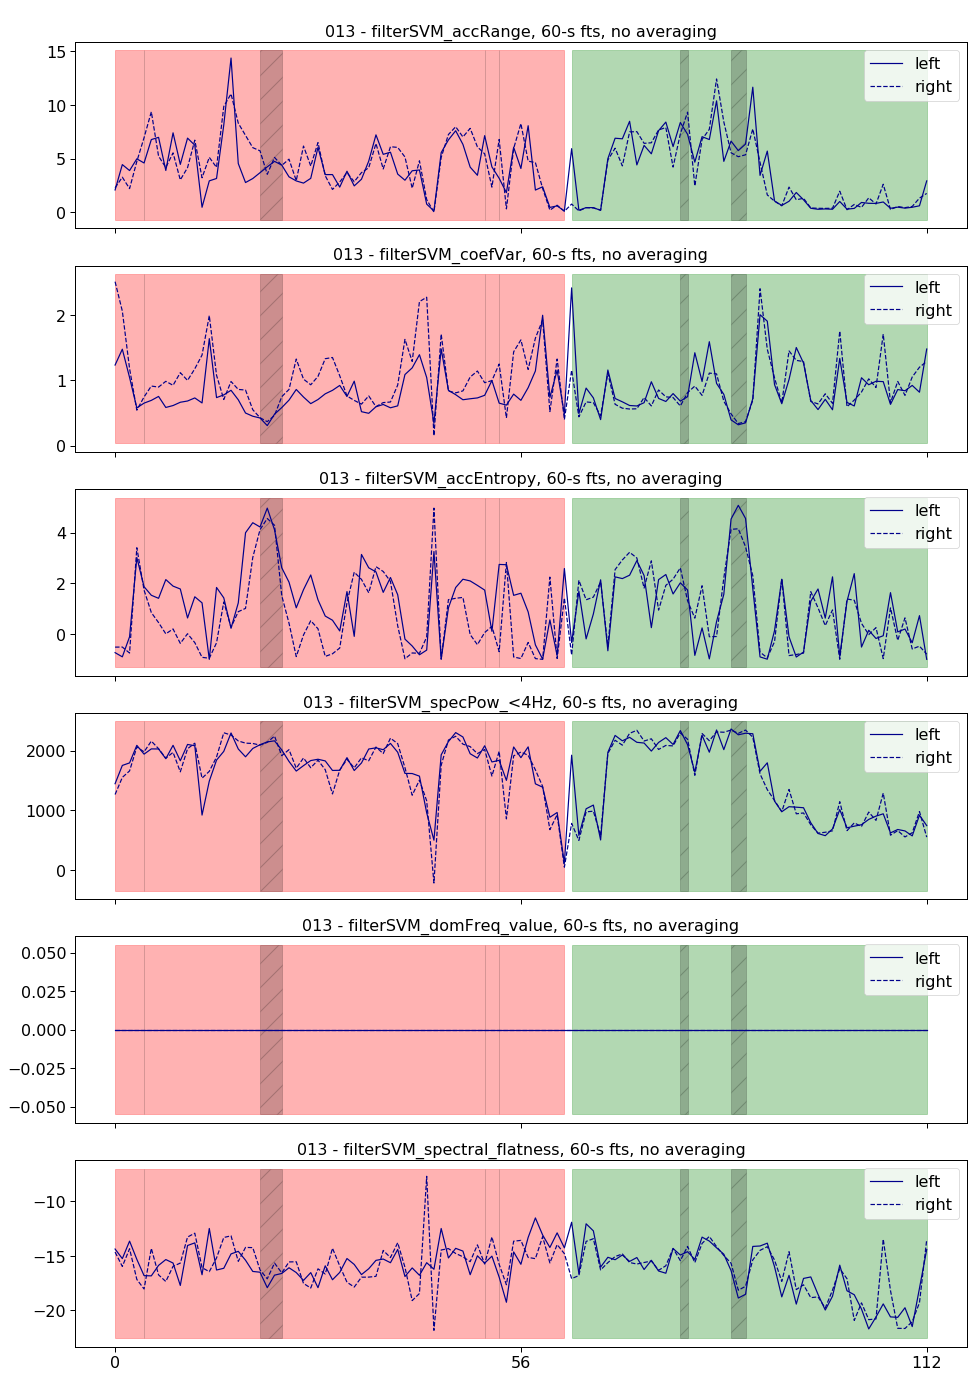

043


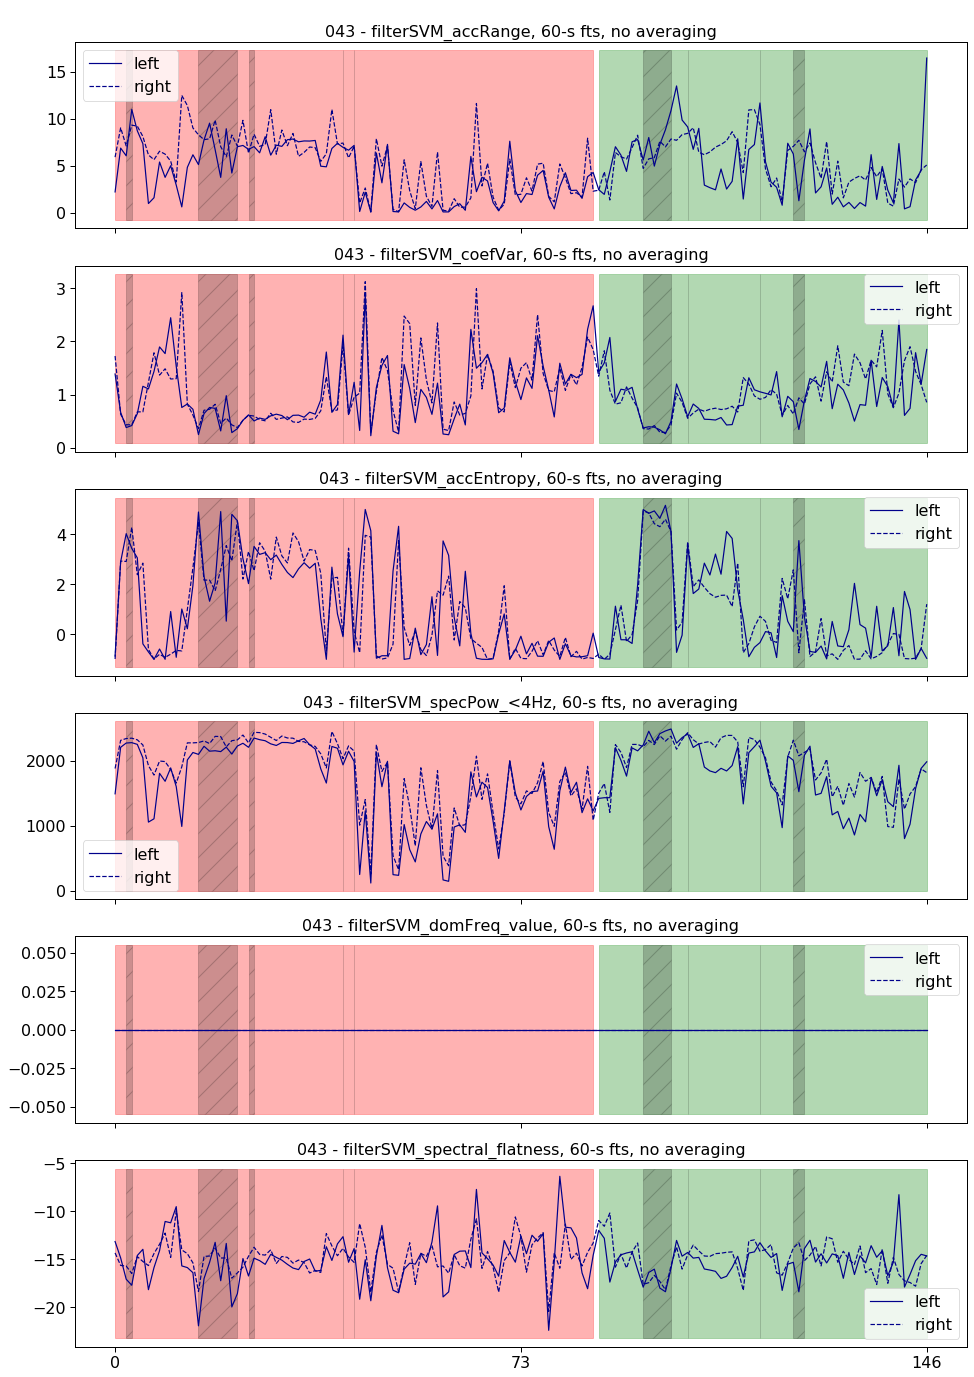

In [84]:
## VISUALIZATION RAW-FEATURES VS PRE/POST-MED AND ACTIVE/PASSIVE - ACTIVITY

# WITH moving average

#'filterSVM_90prcAcc',              'filterSVM_handMov1',


listFeats = ['filterSVM_accRange',  'filterSVM_coefVar','filterSVM_accEntropy',
            'filterSVM_specPow_<4Hz','filterSVM_domFreq_value','filterSVM_spectral_flatness',]

for pt in testData.keys():
    print(pt)
    t0 = 0
    t1 = len(testData[pt]['LW']['Med'].index)
    ticks = np.linspace(t0,t1-1,3).astype(int)
    X_axis = testData[pt]['LW']['Med'].index[t0:t1]

    fig, axes = plt.subplots(len(listFeats), 1, sharex=True, figsize=(16,24) ) #big: 40,240, subplots rows: len(svmKeys)

    for n, feat in enumerate(listFeats):
        # calculating moving average with scipy filter (fastest, same result)
        testData[pt]['LW'][feat+'_smooth'] = uniform_filter1d(testData[pt]['LW'][feat], size = 20) # 1 min = 200 values of 3 sec's
        testData[pt]['RW'][feat+'_smooth'] = uniform_filter1d(testData[pt]['RW'][feat], size = 20) # 1 min = 200 values of 3 sec's

        # define figure axis etc
        yFeatL = testData[pt]['LW'][feat][t0:t1]
        yFeatR = testData[pt]['RW'][feat][t0:t1]
#         yMin = min(min(yFeatL),min(yFeatR))
#         yMax = max(max(yFeatL),max(yFeatR))
        yMed = testData[pt]['LW']['Med'][t0:t1]
        yAct = testData[pt]['LW']['Act'][t0:t1]
        
        fs = 16
        axes[n].plot( yFeatL, label = 'left'  , color = 'darkblue')
#         axes[n].plot(X_axis, testData[pt]['LW'][feat], label = '%s - left' % feat , color = 'darkblue', ls='--')
        axes[n].plot( yFeatR, label = 'right' , color = 'darkblue', ls='--')
#         axes[n].plot( yAct, label = 'Activity' , color = 'orange')
        ymin, ymax = axes[n].get_ylim()

#         axes[n].plot(X_axis, yMed, color = 'darkblue')

        axes[n].set_title('\n%s - %s, 60-s fts, no averaging' % (pt,feat), fontsize=fs)
    # fill for med status
        axes[n].fill_between(X_axis, ymin, ymax, where= yMed==1, color = 'green', alpha = 0.3, ) #hatch = '//'
        axes[n].fill_between(X_axis, ymin, ymax, where= yMed==0, color = 'red', alpha = 0.3, ) #hatch = '//'
# fill for activity
#         axes[n].fill_between(X_axis, ymin, ymax, where= yAct==1, color='black', alpha = 0.1, hatch = '/' ) #
        axes[n].fill_between(X_axis, ymin, ymax, where= yAct==2, color='black',alpha = 0.2, hatch = '/'  ) #hatch = '//'


        axes[n].tick_params(axis='both', labelsize=fs)
        axes[n].set_xticks( ticks = ticks )
        axes[n].set_xticklabels( X_axis[ticks] )
#         axes[n].vlines(medIndx[day],ymin=ymin,ymax=ymax, lw = 3, color='red')
        axes[n].legend(fontsize=16)



    plt.show()





In [86]:
## CLASSIFIER COMPARISON

# create dataframe, each row one patient-side, two rows per patient; each column a classifier, fill with mean auc over cv
classifiers = ['LogReg', 'RndFor', 'SVC']

ptSidesLabels=[]
for p,pt in enumerate(testData.keys()):
    for s,side in enumerate(testData[pt].keys()):
        ptSidesLabels.append(pt+'_'+side)
aucTable= pd.DataFrame(data=np.zeros((len(testData.keys())*2,len(classifiers))),columns=classifiers, index=ptSidesLabels)
# aucTable = pd.DataFrame(data=ptSidesLabels, columns = ['Id/side'])
# aucTable = pd.concat([aucTable,z], axis=1)
        
# to be filled later in cells; PM add different settings for classifiers


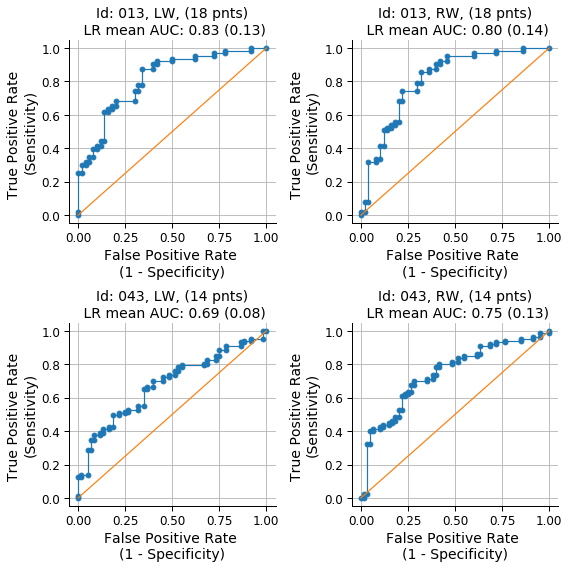

In [109]:
# LOGISTIC REGRESSION classification, predicting pre vs post med

preds = featLabels

nFolds = 10
# create dataframe to store scores per pt-side
logregScores={}
        
# saving feature weights 
logregWeights = pd.DataFrame(data=np.zeros((len(preds),2*len(testData.keys()))), 
                             columns = ptSidesLabels, index=preds)
lrStd = pd.DataFrame(data=np.zeros((len(preds),2*len(testData.keys()))), 
                             columns = ptSidesLabels, index=preds)


sns.set_context('paper')
fig, axes= plt.subplots(len(testData.keys()), 2, figsize=(8,4*len(testData.keys())))

for n,pt in enumerate(list(testData.keys())):
    for s,side in enumerate(['LW', 'RW']):
        predData = testData[pt][side].sample(frac=1) # sample shuffles rows randomly, frac=1 means every row comes back
        scaler = StandardScaler()
        scaler.fit(predData[preds])
        xData = pd.DataFrame(data = scaler.transform(predData[preds]), columns = preds)
        est=LogisticRegression(solver='lbfgs', max_iter = 500) #liblinear
        x= xData[preds].values
        y= predData['Med'].values == 0
        kf = KFold(n_splits=nFolds)
        weights=np.zeros((nFolds,len(preds)))
        scores = np.zeros((y.shape[0],2))
        aucs=[]
        # create array to save scores
        logregScores[pt+'_'+side] = pd.DataFrame(data= predData['Med'], columns=['Med'])
        logregScores[pt+'_'+side]['probA'] = np.zeros((y.shape[0]))
        logregScores[pt+'_'+side]['probB'] = np.zeros((y.shape[0]))

        for fold, (train,test) in enumerate(kf.split(x)): 
            est.fit(x[train,:],y[train])
            scores[test,:] = est.predict_proba(x[test,:])
            weights[fold,:] = est.coef_
            aucs.append(roc_auc_score(y[test]==1, scores[test,1]))
            logregScores[pt+'_'+side].loc[test,1:] = scores[test,:]
        auc = roc_auc_score(y==1, scores[:,1])
        (fpr, tpr, treshs) = roc_curve(y==1, scores[:,1])
        
        # relative normalization of weights
        w = (np.exp(np.mean(weights, axis=0))-1)*100
        logregWeights[pt+'_'+side] = w
        w_std =(np.exp(np.std(weights, axis=0))-1) * 100
        lrStd[pt+'_'+side] = w_std

#         print('\n ID: %s, for side: %s' % (pt,side))
#         print('AUC:',round(auc,2))
#         print('Mean (sd) AUC over cross-val:',np.mean(aucs), np.std(aucs))
        aucTable.iloc[2*n+s]['LogReg'] = round(np.mean(aucs),2)
        # Figures
        axes[n,s].plot(fpr,tpr,'o-')
        axes[n,s].plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
        axes[n,s].set_title('Id: %s, %s, (%.0f pnts)\n LR mean AUC: %.2f (%.2f)' % (pt,side,updrsList[n],np.mean(aucs), np.std(aucs)), fontsize=14)
        axes[n,s].set_xlabel('False Positive Rate \n(1 - Specificity)', fontsize=14)
        axes[n,s].set_ylabel('True Positive Rate \n(Sensitivity)',fontsize=14)
        axes[n,s].tick_params(axis='both', labelsize=12)
        sns.despine()
        axes[n,s].grid()
plt.tight_layout()
plt.show()
        
        

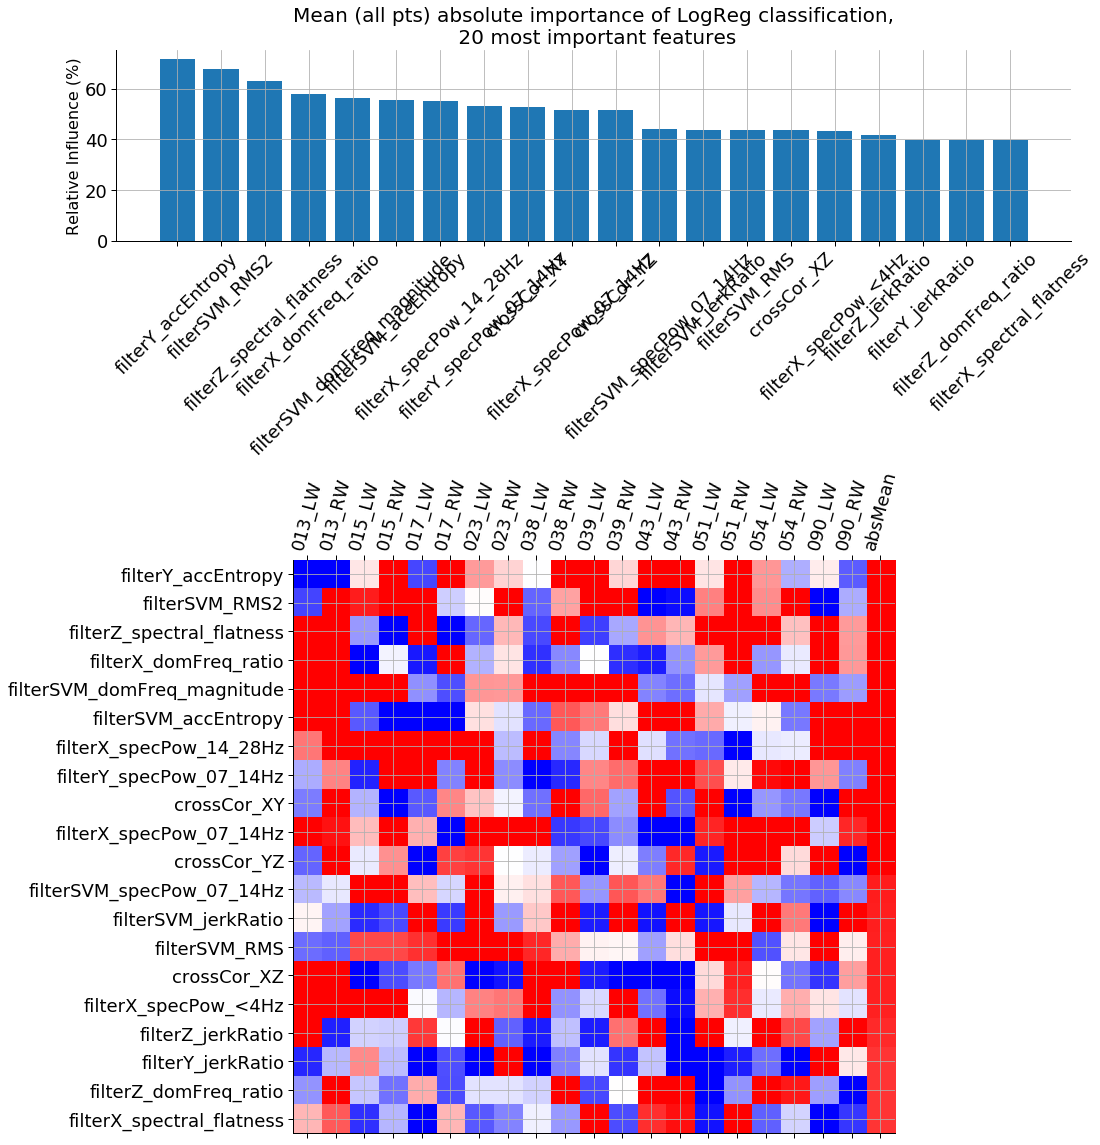

In [21]:
# visualizing importance of features in LogReg model

labels=list(logregWeights.index)
logregWeights['absMean'] = np.zeros(logregWeights.shape[0])
for row in labels:
    m = np.mean(np.abs(logregWeights.loc[row][:-1]))
    logregWeights.loc[row]['absMean'] = m

# show in order of magnitude
sortLRweights = np.argsort(logregWeights['absMean'])[::-1]
num = 20 # number of strongest features to show

# barplot visualization for one model
sns.set_context('paper')
fig, axes= plt.subplots(2,1, figsize=(16,16), gridspec_kw={'height_ratios': [1, 3]})

axes[0].bar(np.arange(len(labels[:num])),logregWeights['absMean'][sortLRweights][:num], ) #yerr=lrStd[s]
axes[0].set_xticks(np.arange(len(labels[:num])), )
axes[0].set_xticklabels(np.array(labels)[sortLRweights][:num], rotation=45)
axes[0].tick_params(labelsize=18)
axes[0].grid()
axes[0].set_ylabel('Relative Influence (%)', fontsize=16)
axes[0].set_title('Mean (all pts) absolute importance of LogReg classification,\n %i most important features' % num, fontsize=20)

axes[1].matshow(np.array(logregWeights)[sortLRweights][:num],  cmap='bwr', vmin=-50,vmax=50)      # fignum = 1  is to use the enlarged figure frame   
axes[1].set_xticks(np.arange(len(logregWeights.keys())), )
axes[1].set_xticklabels(logregWeights.keys(), rotation= 75)
axes[1].set_yticks(np.arange(len(labels[:num])), )
axes[1].set_yticklabels(np.array(labels)[sortLRweights][:num],rotation= 0)
axes[1].tick_params(labelsize=18)
axes[1].grid()

sns.despine()
plt.tight_layout()
plt.show()


In [22]:
## individual feature importance
ftLabels = list(logregWeights.index)

# show in order of magnitude
for ptSide in logregWeights.keys()[:-1]:
    
    indLRweightSort = np.argsort(logregWeights[ptSide])[::-1]
    num = 10 # number of strongest features to show
    
    print('\n%s most important abs features for %s:' % (str(num),ptSide))
    print(np.array(ftLabels)[indLRweightSort][:num])
    
    
    


10 most important abs features for 013_LW:
['filterX_domFreq_ratio' 'filterZ_spectral_flatness'
 'filterSVM_domFreq_magnitude' 'filterSVM_specPow_<4Hz'
 'filterX_specPow_<4Hz' 'filterSVM_specPow_14_28Hz' 'filterX_accEntropy'
 'crossCor_XZ' 'filterSVM_spectral_flatness' 'filterSVM_accEntropy']

10 most important abs features for 013_RW:
['filterX_domFreq_ratio' 'filterZ_spectral_flatness' 'crossCor_YZ'
 'filterZ_accEntropy' 'crossCor_XY' 'filterX_specPow_14_28Hz'
 'filterX_specPow_<4Hz' 'filterSVM_accEntropy' 'filterSVM_RMS2'
 'filterZ_domFreq_value']

10 most important abs features for 015_LW:
['filterSVM_specPow_07_14Hz' 'filterX_specPow_<4Hz'
 'filterSVM_domFreq_magnitude' 'filterX_specPow_14_28Hz'
 'filterSVM_specPow_<4Hz' 'filterZ_accEntropy' 'filterX_domFreq_value'
 'filterSVM_maxAcc' 'filterSVM_accRange' 'filterY_specPow_<4Hz']

10 most important abs features for 015_RW:
['filterY_accEntropy' 'filterY_specPow_07_14Hz' 'filterSVM_RMS2'
 'filterSVM_specPow_07_14Hz' 'filterSVM_domF

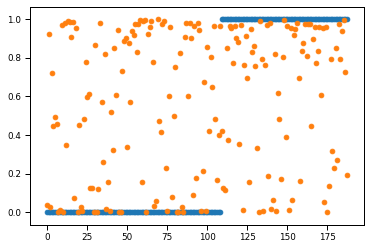

In [71]:
plt.scatter(logregScores['051_RW'].index,logregScores['051_RW']['Med'])

plt.scatter(logregScores['051_RW'].sort_index().index, logregScores['051_RW'].sort_index()['probB'])
sns.lmplot


In [99]:
logregScores.keys()

dict_keys(['013_LW', '013_RW', '043_LW', '043_RW'])

0 013_LW
1 013_RW
2 043_LW
3 043_RW


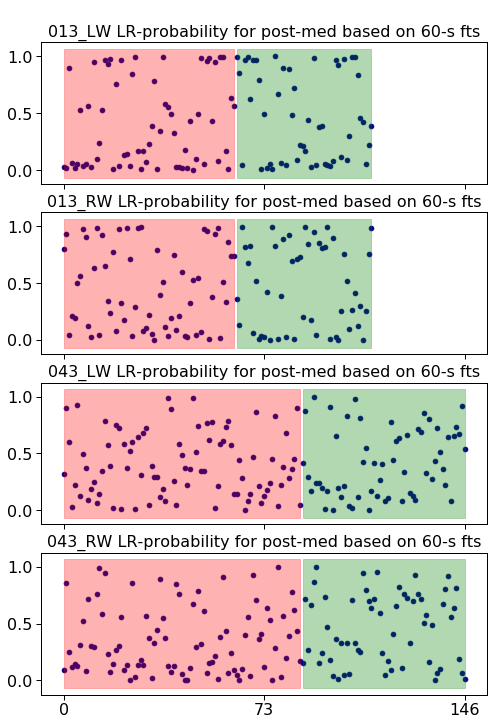

In [111]:
fig, axes = plt.subplots(len(logregScores.keys()), 1, sharex=True, figsize=(8,12) ) #big: 40,240, subplots rows: len(svmKeys)



for n,ptSide in enumerate(logregScores.keys()):
    print(n,ptSide)
    t0 = 0
    t1 = len(logregScores[ptSide]['Med'].index)
    ticks = np.linspace(t0,t1-1,3).astype(int)
    X_axis = logregScores[ptSide].sort_index()['Med'].index[t0:t1]

    yMed = logregScores[ptSide].sort_index()['Med'][t0:t1]
    yPred = logregScores[ptSide].sort_index()['probA'][t0:t1]

    fs = 16
    axes[n].scatter(X_axis, yPred,  color = 'darkblue')
    ymin, ymax = axes[n].get_ylim()

    axes[n].set_title('\n%s LR-probability for post-med based on 60-s fts' % ptSide, fontsize=fs)
# fill for med status
    axes[n].fill_between(X_axis, ymin, ymax, where= yMed==1, color = 'green', alpha = 0.3, ) #hatch = '//'
    axes[n].fill_between(X_axis, ymin, ymax, where= yMed==0, color = 'red', alpha = 0.3, ) #hatch = '//'

    axes[n].tick_params(axis='both', labelsize=fs)
    axes[n].set_xticks( ticks = ticks )
    axes[n].set_xticklabels( X_axis[ticks] )
#     axes[n].legend(fontsize=16)



plt.show()


In [23]:
# ## LOG REG OUTCOME AVERGAING

# ### features and med states are given per 3 seconds - goal is to get to scores every 10-minutes
# #  logregScores is created in predictive model cell, stored all probabilities (3hz) per session pt-side
# lgMeanScores = {}
# for ptSide in logregScores.keys():
#     # logregScores scores are in random order bcs of cross-val (with: ().sample  )
#     sortedProbs = logregScores[ptSide].sort_index() # sorts scores back to index order (chronological)
    
#     lgMeanScores[ptSide] = pd.DataFrame(data = sortedProbs['Med'][::60].reset_index(drop=True), columns=['Med'])
#     lgMeanScores[ptSide]['meanA'] = np.zeros(len(lgMeanScores[ptSide]['Med']))
#     lgMeanScores[ptSide]['meanB'] = np.zeros(len(lgMeanScores[ptSide]['Med']))

#     for row in np.arange(lgMeanScores[ptSide].shape[0]):
#         lgMeanScores[ptSide]['meanA'].loc[row] = np.mean(sortedProbs['probA'][row*60:60+row*60])
#         lgMeanScores[ptSide]['meanB'].loc[row] = np.mean(sortedProbs['probB'][row*60:60+row*60])

#     # calculating roc of auc for mean prob's
#     auc = roc_auc_score(lgMeanScores[ptSide]['Med'], lgMeanScores[ptSide]['meanB'])
#     print('AUC for %s: %f' % (ptSide,round(auc,2)))


013 done
043 done


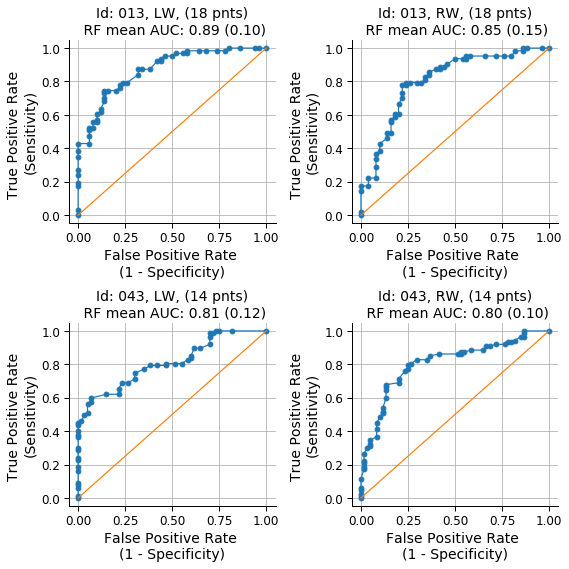

In [108]:
# RANDOM FOREST classification, predicting pre vs post med


preds = featLabels
nFolds = 10
rfImp = pd.DataFrame(data=np.zeros((len(preds),2*len(testData.keys()))), 
                             columns = ptSidesLabels, index=preds)
rfStds = pd.DataFrame(data=np.zeros((len(preds),2*len(testData.keys()))), 
                             columns = ptSidesLabels, index=preds)

# create dataframe to store scores per pt-side
rForestScores={}

sns.set_context('paper')
fig, axes= plt.subplots(len(testData.keys()), 2, figsize=(8,4*len(testData.keys())))

for n,pt in enumerate(list(testData.keys())[:]):
    for s,side in enumerate(['LW', 'RW']):
        # frac=1 shuffles data to mix pre and post
        predData = testData[pt][side].sample(frac=1) # sample shuffles rows randomly, frac=1 means every row comes back
        # standarize data to prevent convergence warnings in LogReg (use predData[preds].values if w/o scaler)
        scaler = StandardScaler()
        scaler.fit(predData[preds])
        x = pd.DataFrame(data = scaler.transform(predData[preds]), columns = preds).values
        y= predData['Med'].values == 0
        #split training/test set -> in K-fold CV
        # RFClass, n_est is 100 by default' gini default criterion for quality of split (or 'entropy')
        est= RandomForestClassifier(n_estimators=100, criterion='gini',)
        
        kf = KFold(n_splits=nFolds)
        importances=np.zeros((nFolds,len(preds)))
        scores = np.zeros((y.shape[0],2))
        aucs=[]
        
        # create array to save scores
        rForestScores[pt+'_'+side] = pd.DataFrame(data= predData['Med'], columns=['Med'])
        rForestScores[pt+'_'+side]['probA'] = np.zeros((y.shape[0]))
        rForestScores[pt+'_'+side]['probB'] = np.zeros((y.shape[0]))


        for fold, (train,test) in enumerate(kf.split(x)): 
            est.fit(x[train,:],y[train])
            scores[test,:] = est.predict_proba(x[test,:])
            importances[fold,:] = est.feature_importances_
            aucs.append(roc_auc_score(y[test]==1, scores[test,1]))
            rForestScores[pt+'_'+side].loc[test,1:] = scores[test,:]
        (fpr, tpr, treshs) = roc_curve(y==1, scores[:,1])
        aucTable.iloc[2*n+s]['RndFor'] = round(np.mean(aucs),2)
        
        # writing weights into designated dataframe
        imp = pd.DataFrame(data = importances.T, index=preds, columns=np.arange(0,nFolds))
        imp['mean'] = np.zeros(imp.shape[0])
        imp['std'] = np.zeros(imp.shape[0])
        for row in imp.index:
            imp.loc[row]['mean'] = np.mean(imp.loc[row][:-2])
            rfImp[pt+'_'+side] = imp['mean']
            imp.loc[row]['std'] = np.std(imp.loc[row][:-2])
            rfStds[pt+'_'+side] = imp['std']

        # Figures
        axes[n,s].plot(fpr,tpr,'o-')
        axes[n,s].plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
        axes[n,s].set_title('Id: %s, %s, (%.0f pnts)\n RF mean AUC: %.2f (%.2f)' % (pt,side,updrsList[n],np.mean(aucs), np.std(aucs)), fontsize=14)
        axes[n,s].set_xlabel('False Positive Rate \n(1 - Specificity)', fontsize=14)
        axes[n,s].set_ylabel('True Positive Rate \n(Sensitivity)',fontsize=14)
        axes[n,s].tick_params(axis='both', labelsize=12)
        sns.despine()
        axes[n,s].grid()
    print(pt,'done')
plt.tight_layout()
plt.show()
        
        



0 013_LW
1 013_RW
2 043_LW
3 043_RW


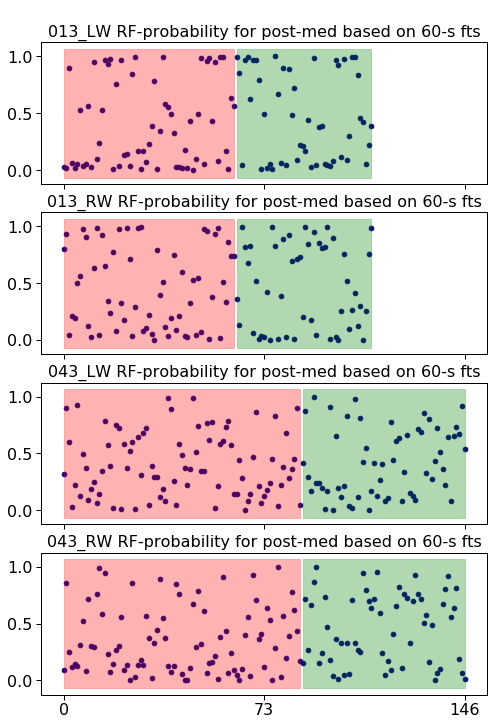

In [112]:
fig, axes = plt.subplots(len(rForestScores.keys()), 1, sharex=True, figsize=(8,12) ) #big: 40,240, subplots rows: len(svmKeys)



for n,ptSide in enumerate(rForestScores.keys()):
    print(n,ptSide)
    t0 = 0
    t1 = len(rForestScores[ptSide]['Med'].index)
    ticks = np.linspace(t0,t1-1,3).astype(int)
    X_axis = rForestScores[ptSide].sort_index()['Med'].index[t0:t1]

    yMed = logregScores[ptSide].sort_index()['Med'][t0:t1]
    yPred = logregScores[ptSide].sort_index()['probA'][t0:t1]

    fs = 16
    axes[n].scatter(X_axis, yPred,  color = 'darkblue')
    ymin, ymax = axes[n].get_ylim()

    axes[n].set_title('\n%s RF-probability for post-med based on 60-s fts' % ptSide, fontsize=fs)
# fill for med status
    axes[n].fill_between(X_axis, ymin, ymax, where= yMed==1, color = 'green', alpha = 0.3, ) #hatch = '//'
    axes[n].fill_between(X_axis, ymin, ymax, where= yMed==0, color = 'red', alpha = 0.3, ) #hatch = '//'

    axes[n].tick_params(axis='both', labelsize=fs)
    axes[n].set_xticks( ticks = ticks )
    axes[n].set_xticklabels( X_axis[ticks] )
#     axes[n].legend(fontsize=16)



plt.show()




Text(0.5, 1.0, 'Random Forest 051_LW (60-s fts)')

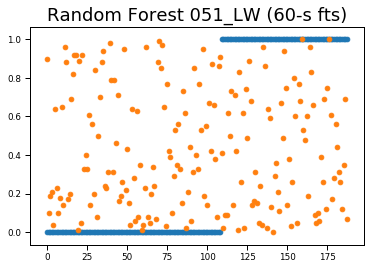

In [79]:
plt.scatter(rForestScores['051_LW'].index,rForestScores['051_LW']['Med'])

plt.scatter(rForestScores['051_LW'].sort_index().index, rForestScores['051_LW'].sort_index()['probA'])
plt.title('Random Forest 051_LW (60-s fts)', size=18)



In [31]:
# ##  OUTCOME AVERGAING -> CHECK FOR RANDOM FOREST!!

# ### features and med states are given per 3 seconds - goal is to get to scores every 10-minutes
# #  logregScores is created in predictive model cell, stored all probabilities (3hz) per session pt-side
# rfMeanScores = {}
# for ptSide in rForestScores.keys():
#     # logregScores scores are in random order bcs of cross-val (with: ().sample  )
#     sortedProbs = rForestScores[ptSide].sort_index() # sorts scores back to index order (chronological)
    
#     rfMeanScores[ptSide] = pd.DataFrame(data = sortedProbs['Med'][::60].reset_index(drop=True), columns=['Med'])
#     rfMeanScores[ptSide]['meanA'] = np.zeros(len(rfMeanScores[ptSide]['Med']))
#     rfMeanScores[ptSide]['meanB'] = np.zeros(len(rfMeanScores[ptSide]['Med']))

#     for row in np.arange(lgMeanScores[ptSide].shape[0]):
#         rfMeanScores[ptSide]['meanA'].loc[row] = np.mean(sortedProbs['probA'][row*60:60+row*60])
#         rfMeanScores[ptSide]['meanB'].loc[row] = np.mean(sortedProbs['probB'][row*60:60+row*60])

#     # calculating roc of auc for mean prob's
#     auc = roc_auc_score(rfMeanScores[ptSide]['Med'], rfMeanScores[ptSide]['meanB'])
#     print('AUC for %s: %f' % (ptSide,round(auc,2)))



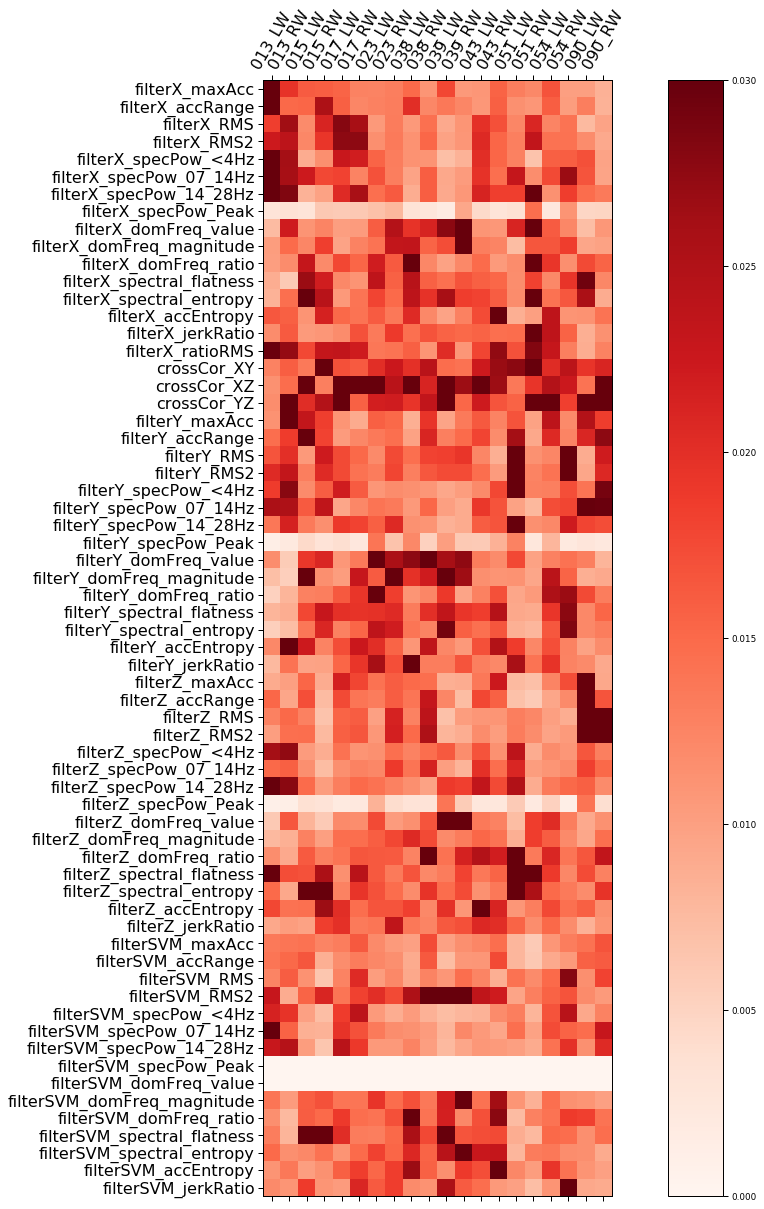

In [32]:
plotData = rfImp[list(rfImp.columns)[:]]

plt.figure(figsize=(20,20)) # use to enlarge size of figure 
plt.matshow(plotData, fignum=1, cmap='Reds', vmin= 0,vmax= 0.03)      # fignum = 1  is to use the enlarged figure frame   
plt.colorbar()
plt.xticks(np.arange(len(plotData.keys())), plotData.keys(), fontsize=16, rotation= 60)
plt.yticks(np.arange(len(plotData.index)), plotData.index,fontsize=16, rotation= 0)
plt.show()


In [33]:
rfImp['absMean'] = np.zeros(rfImp.shape[0])
rfImp['std'] = np.zeros(rfImp.shape[0])



for row in rfImp.index:
    m = np.mean(np.abs(rfImp.loc[row][:]))
    rfImp.loc[row]['absMean'] = m
    rfImp.loc[row]['std'] = np.std(rfImp.loc[row][:])
    

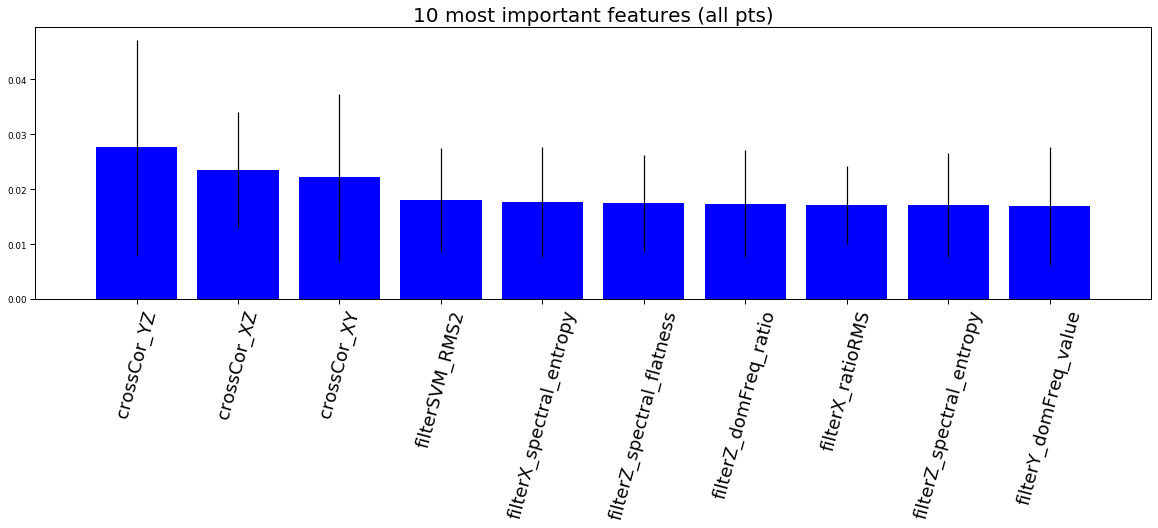

In [34]:
# barplot with std dev's of mean importances over all pt's and all cv-folds

indices = rfImp['absMean'].argsort()[::-1]

num = 10 # all=rfImp.shape[0]


# # Plot the feature importances of the forest
# fig_mif = plt.figure()
# plt.title("{} Most important features".format(featureRange))
# plt.bar(range(featureRange), importances[indices[0:featureRange]],
#        color="b", yerr=std[indices[0:featureRange]], align="center")
# plt.xticks(range(featureRange), X_bin.columns.values[indices[0:featureRange]], rotation=90)
# plt.xlim([-1, featureRange])
# plt.xlabel('Feature')
# plt.ylabel('Relative importance')
# fig_mif.set_figheight(5)
# fig_mif.set_figwidth(15)
# plt.show()
#fig_mif.savefig('50_most_important_features.png')
    
# Plot the feature importances of the forest
fig = plt.figure(figsize=(24,16))
plt.title("%i most important features (all pts)" % num, size=20)
plt.bar(range(num), rfImp['absMean'][indices][:num],   
        color="b", yerr=rfImp['std'][indices][:num], align="center")
plt.xticks(range(num), rfImp.index[indices][:num],rotation=75, fontsize=18)
plt.xlim([-1, num])
fig.set_figheight(5)
fig.set_figwidth(20)
plt.show()

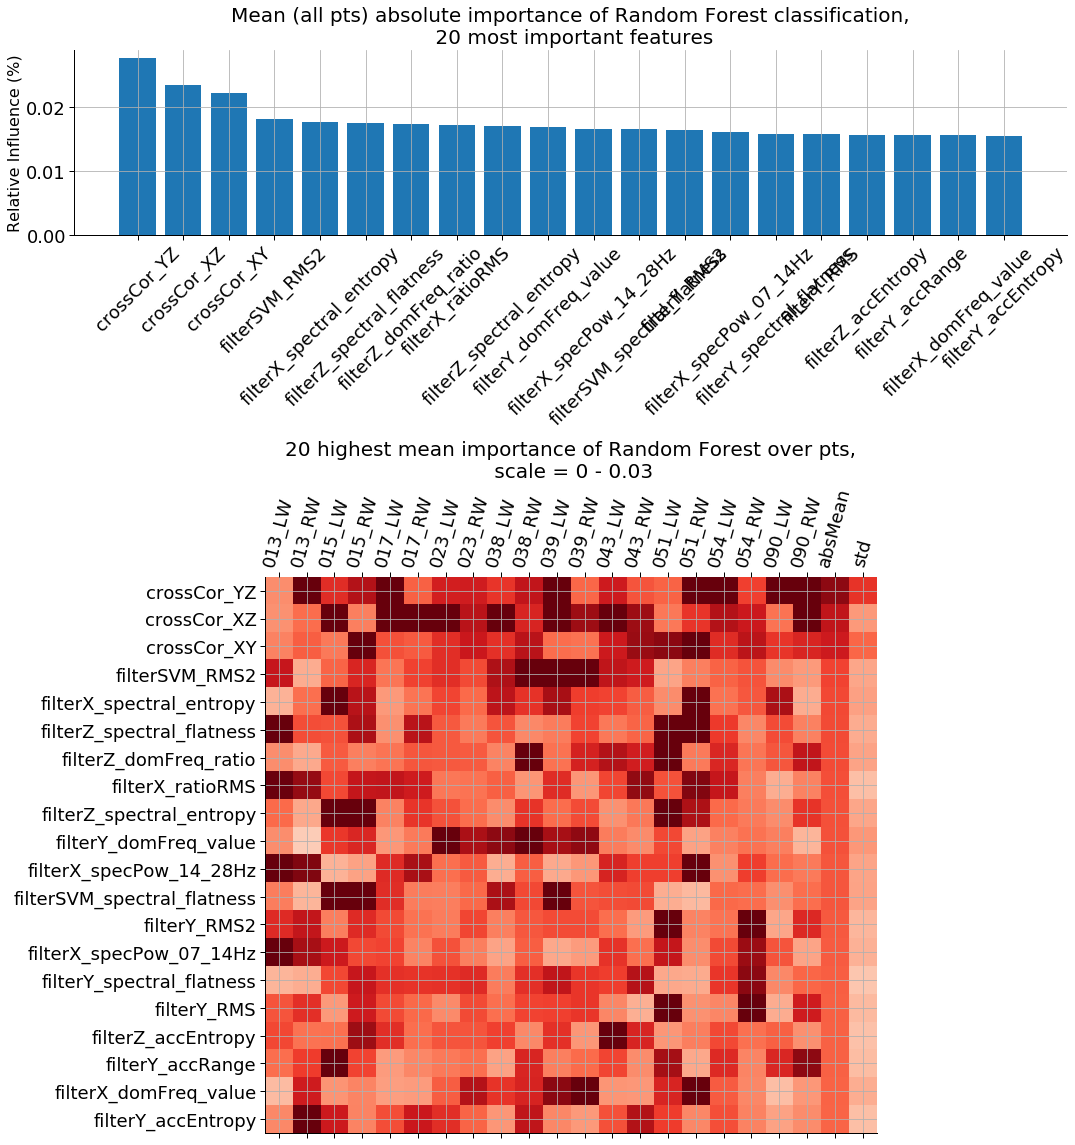

In [35]:
# visualizing importance of features in random forest model

labels=list(rfImp.index)

# show in order of magnitude
sortRFweights = np.argsort(rfImp['absMean'])[::-1]
num = 20 # number of strongest features to show

# barplot visualization for one model
sns.set_context('paper')
fig, axes= plt.subplots(2,1, figsize=(16,16), gridspec_kw={'height_ratios': [1, 3]})

axes[0].bar(np.arange(len(labels[:num])),rfImp['absMean'][sortRFweights][:num], ) #yerr=lrStd[s]
axes[0].set_xticks(np.arange(len(labels[:num])), )
axes[0].set_xticklabels(np.array(labels)[sortRFweights][:num], rotation=45)
axes[0].tick_params(labelsize=18)
axes[0].grid()
axes[0].set_ylabel('Relative Influence (%)', fontsize=16)
axes[0].set_title('Mean (all pts) absolute importance of Random Forest classification,\n %i most important features' % num, fontsize=20)

axes[1].matshow(np.array(rfImp)[sortRFweights][:num],  cmap='Reds', vmin=0,vmax=0.03)      # fignum = 1  is to use the enlarged figure frame   
axes[1].set_xticks(np.arange(len(rfImp.keys())), )
axes[1].set_xticklabels(rfImp.keys(), rotation= 75)
axes[1].set_yticks(np.arange(len(labels[:num])), )
axes[1].set_yticklabels(np.array(labels)[sortRFweights][:num],rotation= 0)
axes[1].tick_params(labelsize=18)
axes[1].set_title('%i highest mean importance of Random Forest over pts,\n scale = 0 - 0.03\n\n\n' % num, fontsize=20)
axes[1].grid()

sns.despine()
plt.tight_layout()
plt.show()



013 done
015 done
017 done
023 done
038 done
039 done
043 done
051 done
054 done
090 done


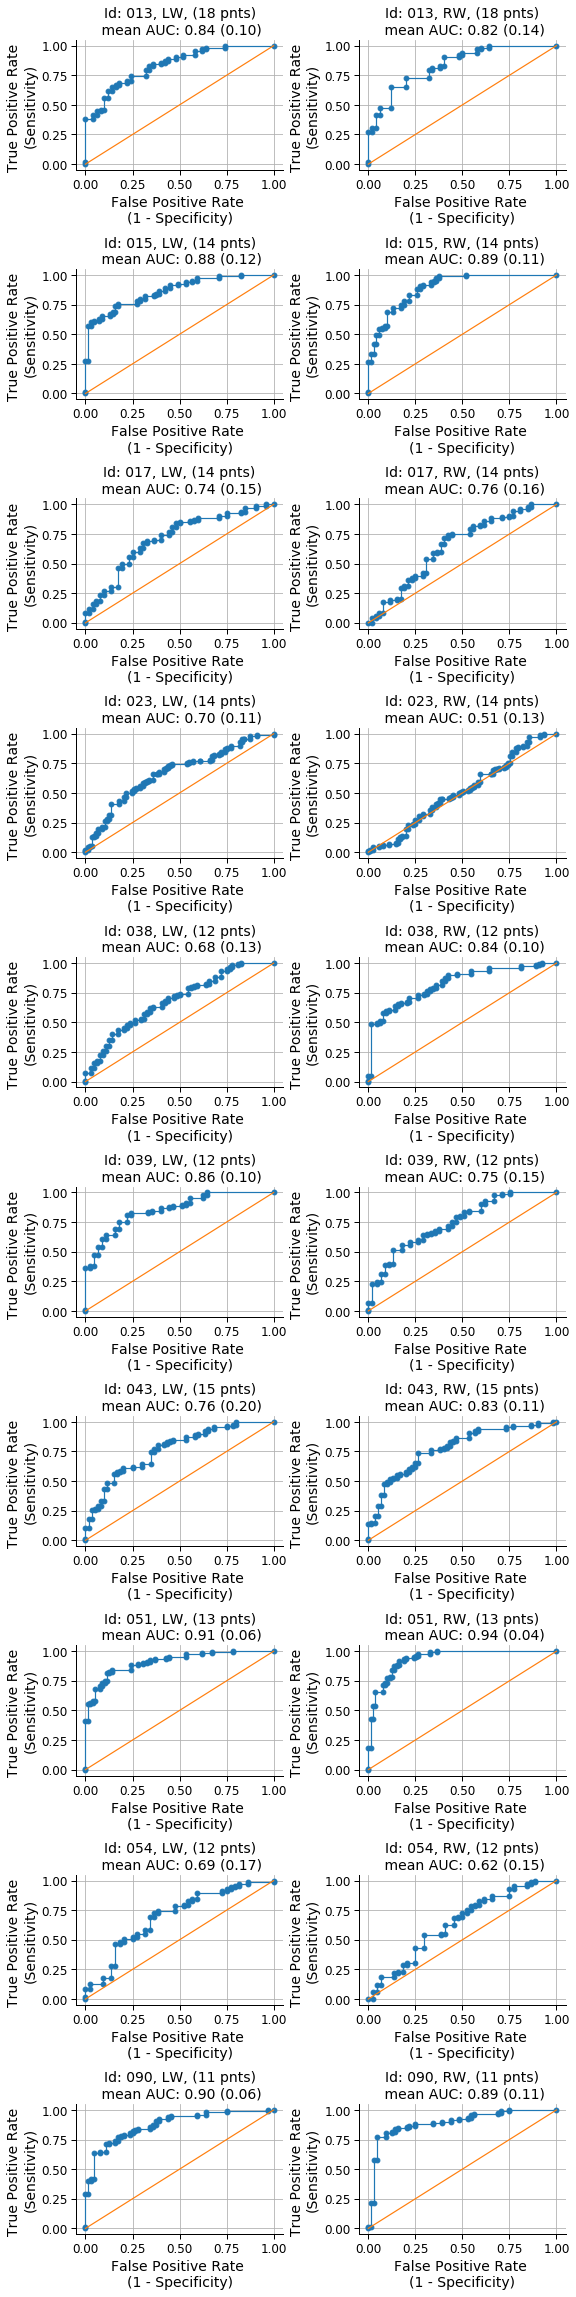

In [57]:
# SVM classification, predicting pre vs post med

  
# add updrs difference per pt!!

preds = featLabels

nFolds = 10

sns.set_context('paper')
fig, axes= plt.subplots(len(featCombi60s.keys()), 2, figsize=(8,32))

for n,pt in enumerate(list(featCombi60s.keys())):
    for s,side in enumerate(['LW', 'RW']):
        # frac=1 shuffles data to mix pre and post
        predData = featCombi60s[pt][side].sample(frac=1) # sample shuffles rows randomly, frac=1 means every row comes back
        # standarize data to prevent convergence warnings in LogReg (use predData[preds].values if w/o scaler)
        scaler = StandardScaler()
        scaler.fit(predData[preds])
        x = pd.DataFrame(data = scaler.transform(predData[preds]), columns = preds).values
        y= predData['Med'].values == 0
        #split training/test set -> in K-fold CV
        # RFClass, n_est is 100 by default' gini default criterion for quality of split (or 'entropy')
        est= SVC(gamma='auto')
###
#         weights=np.zeros((nFolds,len(preds)))
#         scores = np.zeros((y.shape[0],2))
#         aucs=[]
#         for fold, (train,test) in enumerate(kf.split(x)): 
#             est.fit(x[train,:],y[train])
#             #scores[test,:] = est.predict_proba(x[test,:])
#             if hasattr(est, "predict_proba"):
#                 prob_pos = est.predict_proba(x[test,:])#[:, 0]
#             else:  # use decision function
#                 prob_pos = est.decision_function(x[test,:])
#                 #prob_pos = \
#                 #    (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
#             scores[test,:]=prob_pos
#             #importances[fold,:] = est.feature_importances_
#             weights[fold,:] = est.coef_
#             aucs.append(roc_auc_score(y[test]==1, scores[test,1]))
#         #scores = cross_val_score(est,x,y,cv=KFold(10))
#         auc = roc_auc_score(y==1, scores[:,1])
#         (fpr, tpr, treshs) = roc_curve(y==1, scores[:,1])  
###

        kf = KFold(n_splits=nFolds)
#         importances=np.zeros((10,len(preds)))
        scores = np.zeros((y.shape[0],1))
        aucs=[]
        for fold, (train,test) in enumerate(kf.split(x)): 
            est.fit(x[train,:],y[train])
            scores[test,:] = est.decision_function(x[test,:]).reshape(len(test),1)
            aucs.append(roc_auc_score(y[test]==1, scores[test,:]))
        (fpr, tpr, treshs) = roc_curve(y==1, scores)
        aucTable.iloc[2*n+s]['SVC'] = round(np.mean(aucs),2)

        # Figures
        axes[n,s].plot(fpr,tpr,'o-')
        axes[n,s].plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
        axes[n,s].set_title('Id: %s, %s, (%.0f pnts)\n mean AUC: %.2f (%.2f)' % (pt,side,updrsList[n],np.mean(aucs), np.std(aucs)), fontsize=14)
        axes[n,s].set_xlabel('False Positive Rate \n(1 - Specificity)', fontsize=14)
        axes[n,s].set_ylabel('True Positive Rate \n(Sensitivity)',fontsize=14)
        axes[n,s].tick_params(axis='both', labelsize=12)
        sns.despine()
        axes[n,s].grid()
    print(pt,'done')
plt.tight_layout()
plt.show()
        
        




In [73]:
aucTable.iloc[:-2]


,LogReg,RndFor,SVC
013_LW,0.79,0.88,0.84
013_RW,0.83,0.90,0.82
015_LW,0.79,0.86,0.88
015_RW,0.91,0.89,0.89
017_LW,0.67,0.77,0.74
017_RW,0.64,0.70,0.76
023_LW,0.67,0.62,0.70
023_RW,0.54,0.59,0.51
038_LW,0.66,0.75,0.68
038_RW,0.83,0.83,0.84


In [50]:
aucTable
for cls in classifiers:
    print('Mean %s:' % cls,np.mean(aucTable[cls]))

    
for cls in classifiers:
    best = 0
    for r in np.arange(len(featCombi60s.keys())):
        best = best + max([aucTable[cls][2*r],aucTable[cls][2*r+1]])
    bestMean = best/len(featCombi60s.keys())
    print('Mean %s, only best sides :' % cls,round(bestMean,2))
    
    

Mean LogReg: 0.07954545454545454
Mean RndFor: 0.07954545454545454
Mean SVC: 0.07954545454545454
Mean LogReg, only best sides : 0.09
Mean RndFor, only best sides : 0.09
Mean SVC, only best sides : 0.09


# AVERAGING OUT OUTCOME PROBABILITIES

In [43]:
# LOGISTIC REGRESSION classification, predicting pre vs post med


preds = featLabels3s
# create dataframe to store scores per pt-side
logregScores={}

nFolds = 10


sns.set_context('paper')
fig, axes= plt.subplots(len(featCombi3s.keys()), 2, figsize=(8,32))

for n,pt in enumerate(list(featCombi3s.keys())[:2]):
    for s,side in enumerate(['LW', 'RW']):
        predData = featCombi3s[pt][side].sample(frac=1) # sample shuffles rows randomly, frac=1 means every row comes back        
        scaler = StandardScaler()
        scaler.fit(predData[preds])
        xData = pd.DataFrame(data = scaler.transform(predData[preds]), columns = preds)
        est=LogisticRegression(solver='lbfgs', max_iter = 500) #liblinear
        x= xData[preds].values
        y= predData['Med'].values == 0
        kf = KFold(n_splits=nFolds)
        weights=np.zeros((nFolds,len(preds)))
        scores = np.zeros((y.shape[0],2))
        aucs=[]
# create dataframe to store scores per pt-side
logregScores={}
        
        # create array to save scores
        logregScores[pt+'_'+side] = pd.DataFrame(data= predData['Med'], columns=['Med'])
        logregScores[pt+'_'+side]['probA'] = np.zeros((y.shape[0]))
        logregScores[pt+'_'+side]['probB'] = np.zeros((y.shape[0]))
            logregScores[pt+'_'+side].loc[test,1:] = scores[test,:]


        for fold, (train,test) in enumerate(kf.split(x)): 
            est.fit(x[train,:],y[train])
            scores[test,:] = est.predict_proba(x[test,:])
            # store scores in workable array
#             print(scores[test,:])
            logregScores[pt+'_'+side].loc[test,1:] = scores[test,:]
            weights[fold,:] = est.coef_
            aucs.append(roc_auc_score(y[test]==1, scores[test,1]))
        auc = roc_auc_score(y==1, scores[:,1])
        (fpr, tpr, treshs) = roc_curve(y==1, scores[:,1])
        
        # relative normalization of weights
        w = (np.exp(np.mean(weights, axis=0))-1)*100
        logregWeights[pt+'_'+side] = w
        w_std =(np.exp(np.std(weights, axis=0))-1) * 100
        lrStd[pt+'_'+side] = w_std

#         print('\n ID: %s, for side: %s' % (pt,side))
#         print('AUC:',round(auc,2))
#         print('Mean (sd) AUC over cross-val:',np.mean(aucs), np.std(aucs))
        aucTable.loc[aucTable['LogReg'][2*n+s]] = round(np.mean(aucs),2)
        # Figures
        axes[n,s].plot(fpr,tpr,'o-')
        axes[n,s].plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
        axes[n,s].set_title('Id: %s, %s, (%.0f pnts)\n mean AUC: %.2f (%.2f)' % (pt,side,updrsList[n],np.mean(aucs), np.std(aucs)), fontsize=14)
        axes[n,s].set_xlabel('False Positive Rate \n(1 - Specificity)', fontsize=14)
        axes[n,s].set_ylabel('True Positive Rate \n(Sensitivity)',fontsize=14)
        axes[n,s].tick_params(axis='both', labelsize=12)
        sns.despine()
        axes[n,s].grid()
plt.tight_layout()
plt.show()
        
        

IndentationError: unexpected indent (<ipython-input-43-e83388504fe6>, line 31)